In [1]:
#importacion de librerias necesarias

import numpy as np #para trabajar con arrays numéricos.
import matplotlib.pyplot as plt #para hacer gráficos de entrenamiento como curvas de accuracy y loss
from tensorflow.keras.preprocessing.image import ImageDataGenerator #para cargar imágenes desde carpetas y aplicar transformaciones automáticas (como escalado, rotación
from tensorflow.keras.models import Sequential #definir un modelo de red neuronal secuencial (capas apiladas una detrás de otra).
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam  #optimizador que ajusta los pesos del modelo, probamos con Adam primero
from sklearn.metrics import classification_report, confusion_matrix #Para evaluar el rendimiento del modelo una vez que ha hecho predicciones
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import shuffle

In [2]:
#lECTURA DE NUESTROS DATOS Y FIJAMOS VARIABLES
img_size = 48 #definimos una variable para fijar el tamaño (alto y ancho) al que se redimensionarán todas las imágenes antes de pasarlas por la red neurona
batch_size = 32 # sacado de la literatura es el número de imágenes que el modelo procesará a la vez antes de actualizar los pesos - un EPOCH o paso de entrenamiento
epochs = 60 #cuántas veces el modelo verá todo el dataset completo de entrenamiento - lo usaremos en el .fit
ruta_train = r"C:\Users\anaco\Downloads\data\archive\train"
ruta_test = r"C:\Users\anaco\Downloads\data\archive\test"    

In [3]:
#TRATAMIENTO DE IMAGENES
#Leer las imágenes manualmente desde carpetas

#una limpieza pequeña basica de imagenes 

#Almacenar las imágenes en X_train, y las etiquetas como números en y_train (nuestras Y van a ser las emociones que queremos predecir, pero en formato numerico).

#Normalizar las imágenes a [0, 1].

import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# LISTA MANUAL DE ETIQUETAS (según nuestras carpetas)
etiquetas = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Creamos una función para cargar imágenes desde una ruta base, porque tendremos que aplicar esto a nuestras fotos de train y fotos de test. Hacemos 
#una prelimpieza de imagenes negras, blancas, de muy bajo contraste y tamaño incorrecto
def cargar_imagenes_y_etiquetas(ruta_base, etiquetas, img_size):
    X = []
    y = []
    descartadas = []

    for etiqueta in etiquetas:
        ruta_carpeta = fr"{ruta_base}\{etiqueta}\*.jpg"
        for ruta_imagen in glob.glob(ruta_carpeta):
            try:
                img = Image.open(ruta_imagen).convert("L").resize((img_size, img_size))
                arr = np.array(img)

                # 🔍 FILTRO DE IMÁGENES INVÁLIDAS
                if arr.shape != (img_size, img_size):
                    descartadas.append((ruta_imagen, "Tamaño incorrecto"))
                    continue
                elif np.max(arr) < 5:
                    descartadas.append((ruta_imagen, "Imagen negra"))
                    continue
                elif np.min(arr) > 250:
                    descartadas.append((ruta_imagen, "Imagen blanca"))
                    continue
                elif np.var(arr) < 10.0:
                    descartadas.append((ruta_imagen, "Muy bajo contraste"))
                    continue

                X.append(arr)
                y.append(etiqueta)

            except Exception as e:
                descartadas.append((ruta_imagen, f"Error: {e}"))
#normalizamos
    X = np.array(X).reshape(-1, img_size, img_size, 1).astype("float32") / 255.0
    y = np.array(y)

    print(f"🧽 Imágenes descartadas: {len(descartadas)}")
    return X, y

# Cargar TRAIN
X_train, y_train_raw = cargar_imagenes_y_etiquetas(ruta_train, etiquetas, img_size)

# Cargar TEST
X_test, y_test_raw = cargar_imagenes_y_etiquetas(ruta_test, etiquetas, img_size)

# Codificar etiquetas en números
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)  # usar el mismo encoder

# Confirmar formas y carga correcta de datos
print(f"imagenes de entrenamiento normalizadas: {X_train.shape} | etiquetas codificadas: {y_train.shape}")
print(f"imagenes de test normalizadas: {X_test.shape}  | etiquetas codificadas para test: {y_test.shape}")
print("Clases:", le.classes_)

🧽 Imágenes descartadas: 12
🧽 Imágenes descartadas: 1
imagenes de entrenamiento normalizadas: (28697, 48, 48, 1) | etiquetas codificadas: (28697,)
imagenes de test normalizadas: (7177, 48, 48, 1)  | etiquetas codificadas para test: (7177,)
Clases: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


Conclusion: con esos resultados confirmamos que la carga y preprocesamiento del dataset fue correcta y se han descartado algunas imagenes

Por curiosidad y totalmente opcional 
vamos a visualizar una imagen normal vs normalizada. 
Visualmente ambas imágenes se ven igual, porque el ojo no distingue 
entre escala [0–255] y [0–1] si el contraste relativo es el mismo
Pero internamente, los valores de la imagen normalizada están entre 0 y 1, 
y eso es clave para el entrenamiento del modelo

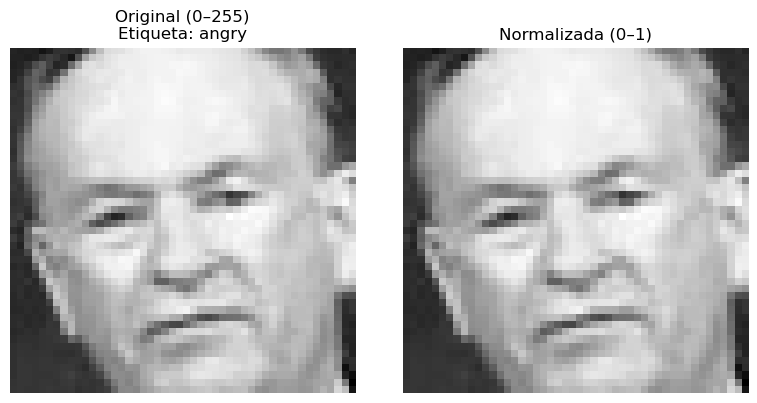

In [4]:
# Seleccionamos una imagen (la 5, por ejemplo)
imagen_normalizada = X_train[5]
etiqueta_codificada = y_train[5]
etiqueta_texto = le.inverse_transform([etiqueta_codificada])[0] # usamos .inverse_transform() para convertir de número a texto (por ejemplo, 4 → 'happy').

# Para comparación, recreamos la imagen original (des-normalizada)
imagen_original = imagen_normalizada * 255

# Convertir a 2D para mostrar
original_2d = imagen_original.reshape(img_size, img_size)
normalizada_2d = imagen_normalizada.reshape(img_size, img_size)

# Dibujar graficamente
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_2d, cmap='gray')
plt.title(f"Original (0–255)\nEtiqueta: {etiqueta_texto}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(normalizada_2d, cmap='gray')
plt.title("Normalizada (0–1)")
plt.axis("off")

plt.tight_layout()
plt.show()

Despues de haber leido literatura, vamos a añadir CBAM
CBAM aplica dos tipos de atención secuencialmente:

1. Atención de canal (Channel Attention)
Se pregunta: ¿Qué filtros o patrones son más importantes?

Ejemplo: ¿debería enfocarme en bordes, arrugas, sombras, cejas…?

2. Atención espacial (Spatial Attention)
Se pregunta: ¿Dónde está la parte importante en la imagen?

Ejemplo: ¿los ojos? ¿la boca? ¿la frente? ¿un ceño fruncido?

Ambas se combinan para mejorar los mapas de características, y así la red se enfoca en lo que realmente importa para predecir una emoción.

Bibliografia
Paper original de CBAM
Título: CBAM: Convolutional Block Attention Module
Autores: Sanghyun Woo, Jongchan Park, Joon-Young Lee, In So Kweon
Publicado en: ECCV 2018
https://arxiv.org/abs/1807.06521

Emotion classification with CBAM on FER2013
https://www.kaggle.com/code/bhosaleajay/fer-cnn-with-cbam-attention

 CBAM attention block in custom CNN
https://www.kaggle.com/code/ritikrai/facial-emotion-detection-cnn-cbam

CBAM module implementation (standalone)
https://www.kaggle.com/code/aakashnain/cbam-module-keras

In [14]:
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Multiply, Conv2D, Concatenate, Activation
import tensorflow as tf

class CBAM(Layer):
    def __init__(self, filters, ratio=8, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.ratio = ratio

    def build(self, input_shape):
        self.shared_dense_one = Dense(self.filters // self.ratio, activation='relu', use_bias=True)
        self.shared_dense_two = Dense(self.filters, use_bias=True)
        self.conv_spatial = Conv2D(filters=1, kernel_size=7, strides=1, padding='same',
                                   activation='sigmoid', use_bias=False)
        super().build(input_shape)

    def call(self, inputs):
        # Channel attention
        avg_pool = GlobalAveragePooling2D()(inputs)
        max_pool = GlobalMaxPooling2D()(inputs)

        avg_pool = Reshape((1, 1, self.filters))(avg_pool)
        max_pool = Reshape((1, 1, self.filters))(max_pool)

        avg_out = self.shared_dense_two(self.shared_dense_one(avg_pool))
        max_out = self.shared_dense_two(self.shared_dense_one(max_pool))

        channel_attention = Activation('sigmoid')(avg_out + max_out)
        channel_refined = Multiply()([inputs, channel_attention])

        # Spatial attention
        avg_pool_spatial = tf.reduce_mean(channel_refined, axis=-1, keepdims=True)
        max_pool_spatial = tf.reduce_max(channel_refined, axis=-1, keepdims=True)
        concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
        spatial_attention = self.conv_spatial(concat)
        refined_feature = Multiply()([channel_refined, spatial_attention])
        return refined_feature

    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'ratio': self.ratio
        })
        return config

In [15]:
#Creamos ahora un modelo de capas CON2D con aumento progrsivo de neuronas par aun efecto lupa
#añadimos tambien batchNormalizacion como en clase
#en esta version mejorada añadimos CBAM


# Número de clases
num_clases = len(np.unique(y_train))  # 7

# Definimos el modelo
model = Sequential([
    Input(shape=(48, 48, 1)),

    # Bloque 1
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),

    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.35),

    # Bloque 2
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),

    MaxPooling2D(pool_size=(2, 2)),

    # CBAM tras Bloque 2
    CBAM(128),

    # Bloque 3
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),

    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # CBAM tras Bloque 3
    CBAM(128),

    # Clasificación
    BatchNormalization(),
    Flatten(),
    Dense(1024),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.6),
    Dense(num_clases, activation='softmax')
])

# Compilamos el modelo con sparse categorical_crossentropy (usamos Adam W ya que vimos en un modelo de HuggingFace que se recomendaba)
model.compile(
    optimizer=AdamW(learning_rate=0.0001, weight_decay=1e-4, epsilon=1e-7),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Text(0, 0.5, 'Cantidad de imágenes')

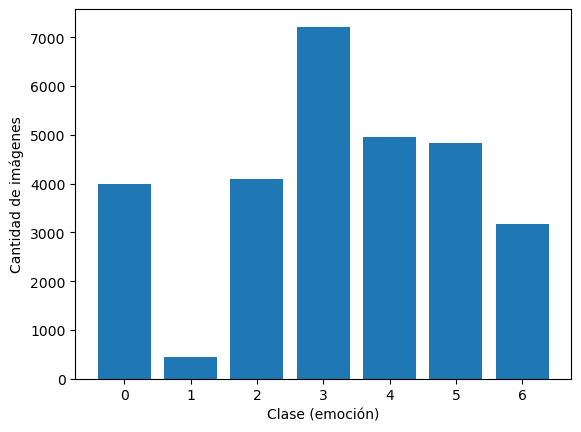

In [7]:
#revisamos el desbalance de clases 
classes, counts = np.unique(y_train, return_counts=True)
plt.bar(classes, counts)
plt.xlabel("Clase (emoción)")
plt.ylabel("Cantidad de imágenes")

Ya hemos visto que nuestras clases estan desbalanceadas. Vamos a aplicar tecnicas de data augmentation en la parte del codigo de abajo

Primero: Detectamos qué clases tienen menos imágenes.

Segundo: Creamos nuevas imágenes para esas clases, aplicando transformaciones visuales (data augmentation).

Tercero: Mezclamos esas nuevas imágenes que hemos creado con las originales.

Luego entrenamos la red neuronal con un conjunto mas equilibrado comparando los resultados con el modelo anterior sin DA

In [8]:
from collections import Counter #en la literatura hemos encontrado esta funcion que nos permite contar cuántas imágenes hay por clase.
from tensorflow.keras.preprocessing.image import ImageDataGenerator #es la funcion de Keras que aplica transformaciones a las imágenes para crear versiones nuevas.

# Contamos cuántas imágenes hay por clase
conteo_clases = Counter(y_train)
max_count = max(conteo_clases.values()) #obtenemos el número de la clase mayoritaria (max_count).
#Esto nos sirve para saber cuántas imágenes debemos generar para igualar las clases minoritarias, y lo guardamos en una variable que usaremos cuando aumentemos las clases.

# Crear generador de augmentación, configurandolo con las modificaciones que queremos hacer a las imagenes creadas
datagen = ImageDataGenerator(
    rotation_range=15,           # 🔁 Rota la imagen aleatoriamente entre -15° y +15°
    width_shift_range=0.05,      # ↔️ Mueve la imagen horizontalmente hasta un 5% del ancho total
    height_shift_range=0.05,     # ↕️ Mueve la imagen verticalmente hasta un 5% de la altura
    zoom_range=0.1,              # 🔍 Hace zoom aleatorio entre 90% y 110% del tamaño original
    horizontal_flip=True,        # 🔄 Invierte horizontalmente la imagen (efecto espejo)
    fill_mode='nearest',         # 🧩 Rellena los píxeles vacíos tras transformaciones usando el valor más cercano
    brightness_range=(0.8, 1.2)  # 💡 Cambia aleatoriamente el brillo entre 80% y 120%
)

# Crear listas para guardar las nuevas imágenes augmentadas
X_augmented = []
y_augmented = []

# Aumentar solo las clases minoritarias
for clase, count in conteo_clases.items():
    if count < max_count:
        num_to_generate = max_count - count
        indices = np.where(y_train == clase)[0]
        X_clase = X_train[indices]

        for i in range(num_to_generate):
            idx = i % len(X_clase)
            image = X_clase[idx]
            image = np.expand_dims(image, 0)
            for batch in datagen.flow(image, batch_size=1):
                X_augmented.append(batch[0])
                y_augmented.append(clase)
                break

# Combinar con datos originales
X_train = np.concatenate([X_train, np.array(X_augmented)])
y_train = np.concatenate([y_train, np.array(y_augmented)])

# Confirmar que ahora todas las clases tienen el mismo número de imágenes
from collections import Counter
print("Conteo de clases tras data augmentation:", Counter(y_train))

Conteo de clases tras data augmentation: Counter({0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214})


In [9]:

#hacemos un shuffle de las imagenes augmentadas

X_train, y_train = shuffle(X_train, y_train, random_state=42)

#dividimos los datos, para que el modelo haga una validacion y ver si se necesita early stopping

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

checkpoint = ModelCheckpoint(
    "CNN_complejo_data_augm_LeakyRelu_60epochs_mejoradoCBAM.h5",
    save_best_only=True,
    monitor="val_loss",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)


# Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, checkpoint])


Epoch 1/60
1184/1184 [==============================] - ETA: 0s - loss: 2.1849 - accuracy: 0.2432
Epoch 1: val_loss improved from inf to 1.75599, saving model to CNN_complejo_data_augm_LeakyRelu_60epochs_mejoradoCBAM.h5
1184/1184 [==============================] - 941s 772ms/step - loss: 2.1849 - accuracy: 0.2432 - val_loss: 1.7560 - val_accuracy: 0.3317
Epoch 2/60
1184/1184 [==============================] - ETA: 0s - loss: 1.9201 - accuracy: 0.2898
Epoch 2: val_loss improved from 1.75599 to 1.66602, saving model to CNN_complejo_data_augm_LeakyRelu_60epochs_mejoradoCBAM.h5
1184/1184 [==============================] - 907s 766ms/step - loss: 1.9201 - accuracy: 0.2898 - val_loss: 1.6660 - val_accuracy: 0.3568
Epoch 3/60
1184/1184 [==============================] - ETA: 0s - loss: 1.7823 - accuracy: 0.3199
Epoch 3: val_loss improved from 1.66602 to 1.57887, saving model to CNN_complejo_data_augm_LeakyRelu_60epochs_mejoradoCBAM.h5
1184/1184 [==============================] - 911s 770ms/st

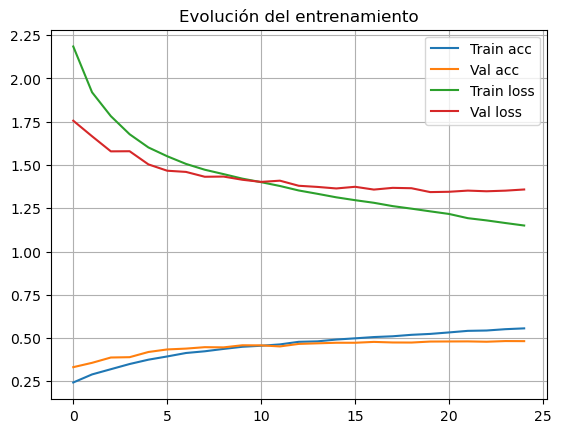

In [17]:
#visualizar las curvas del entrenamiento
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.title("Evolución del entrenamiento")
plt.grid(True)
plt.show()

225/225 [==============================] - 43s 171ms/step
🔍 Clasification Report:

              precision    recall  f1-score   support

       angry       0.48      0.57      0.52       957
     disgust       0.56      0.50      0.53       111
        fear       0.49      0.41      0.44      1024
       happy       0.81      0.82      0.82      1774
     neutral       0.55      0.61      0.58      1233
         sad       0.48      0.43      0.46      1247
    surprise       0.77      0.73      0.75       831

    accuracy                           0.61      7177
   macro avg       0.59      0.58      0.58      7177
weighted avg       0.61      0.61      0.61      7177



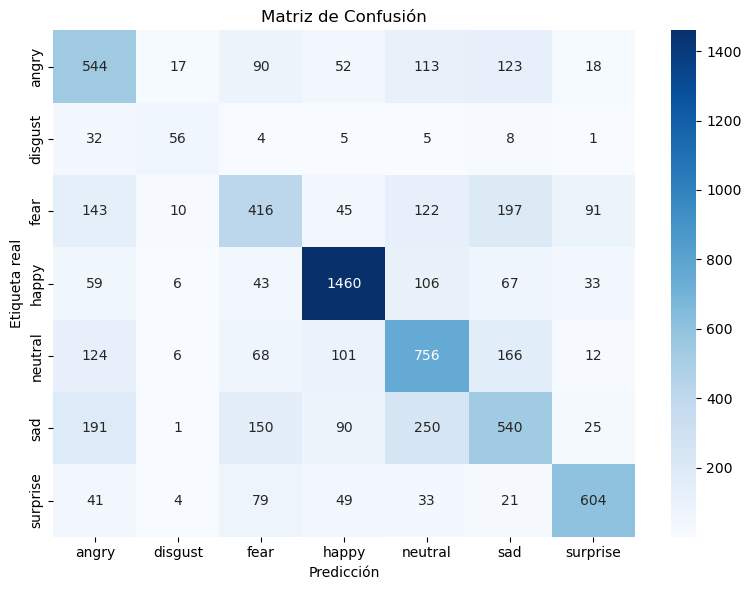

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predicción
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# Reporte por clase
print("🔍 Clasification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()